# Time-based Features and Moving Averages
## LSTM using Recursive Approach (7.3 from report)

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

This notebook preprocesses Bitcoin data by converting timestamps, resampling it to hourly intervals, and engineering time-based and cyclic features (including moving averages).

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Utility Functions

In [ ]:
def add_time_features(df):
    """
    Add time-based features to the DataFrame.
    Features include hour, day, weekday, month, and a weekend indicator.
    """
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return df

In [ ]:
def add_cyclic_features(df):
    """
    Add cyclic sine and cosine representations for time-related features:
    hour, weekday, and month.
    """
    # Cyclic features for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # Cyclic features for weekday
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    # Cyclic features for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load CSV data, convert the unix timestamp to datetime, resample to hourly frequency,
    add time-based and cyclic features, compute moving averages, and drop NaN values.
    """
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Convert unix timestamp to datetime and set it as the index
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)

    # Keep only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    # Resample data to hourly frequency, mean values
    data_hourly = numeric_data.resample('1h').mean()

    # Add time-based features and cyclic representations
    data_hourly = add_time_features(data_hourly)
    data_hourly = add_cyclic_features(data_hourly)

    # Compute moving averages, MA_24 and MA_240
    data_hourly['MA_24'] = data_hourly['close'].rolling(window=24).mean()
    data_hourly['MA_240'] = data_hourly['close'].rolling(window=240).mean()

    # Drop rows with missing values
    data_hourly.dropna(inplace=True)
    return data_hourly

In [ ]:
def split_data(data, train_end_date, test_start_date, test_end_date, feature_columns, target_column):
    """
    Split the data into training and testing sets based on the specified date ranges.
    Only the selected feature columns and target column are retained.
    """
    train_data = data[:train_end_date]
    test_data = data[test_start_date:test_end_date]
    train_data = train_data[feature_columns + [target_column]]
    test_data = test_data[feature_columns + [target_column]]
    return train_data, test_data

In [ ]:
def scale_data(train_data, test_data):
    """
    Scale the training and testing data using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled, scaler

In [ ]:
def create_sequences(features, target, sequence_length):
    """
    Create sequences of features and corresponding targets for time series forecasting.
    Each sequence is of length 'sequence_length', and the target is the value following the sequence.
    """
    x, y = [], []
    for i in range(len(features) - sequence_length):
        x.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(x), np.array(y)

### Model Building Functions

In [ ]:
def build_lstm_model(sequence_length, num_features):
    """
    Build an optimized LSTM model for time series forecasting.
    """
    model = Sequential([
      LSTM(128, return_sequences=True, input_shape=(sequence_length, num_features)),
      BatchNormalization(),
      Dropout(0.2),
      LSTM(128, return_sequences=True),
      BatchNormalization(),
      Dropout(0.2),
      LSTM(128, return_sequences=False),
      BatchNormalization(),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(1)
  ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
def train_model(model, x_train, y_train, batch_size=256, epochs=100, validation_split=0.2, patience=20):
    """
    Train the model using early stopping to prevent overfitting.
    """

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        shuffle=False,
        callbacks=[early_stopping]
    )

    return history

### Prediction and Evaluation Functions

In [ ]:
def predict_test(model, train_scaled, test_scaled, sequence_length, feature_columns, scaler, test_data):
    """
    Generate predictions for the test set using an iterative approach.
    The input sequence is updated with the predicted value and new moving averages are computed.
    """
    # Remove 'MA_24', 'MA_240', and 'close' from test_scaled to retain only time features
    test_scaled_filtered = np.delete(test_scaled, [0, 1, -1], axis=1)

    # Get the last 240 scaled 'close' values from training data last column
    last_close_values = train_scaled[-240:, -1].tolist()

    # Initialize the input sequence with the last sequence_length entries excluding 'close'
    input_sequence = train_scaled[-sequence_length:, :-1].tolist()

    predictions = []

    # Iteratively predict each time step in the test set
    for i in range(len(test_scaled_filtered)):
        # Prepare the input sequence for prediction
        x_input = np.array(input_sequence).reshape(1, sequence_length, len(feature_columns))
        # Predict the next scaled close value
        predicted_value_scaled = model.predict(x_input, verbose=0)[0, 0]
        predictions.append(predicted_value_scaled)

        # Update the close values list with the new prediction
        last_close_values.append(predicted_value_scaled)
        last_close_values.pop(0)

        # Compute moving averages from the updated close values
        ma_24 = np.mean(last_close_values[-24:])
        ma_240 = np.mean(last_close_values[-240:])

        # Retrieve the already scaled time features for the current test time step
        time_features_scaled = test_scaled_filtered[i]

        # Create the new input feature vector with updated moving averages and time features
        next_input_scaled = np.concatenate([[ma_24, ma_240], time_features_scaled])

        # Update the input sequence window for the next prediction
        input_sequence.append(next_input_scaled)
        input_sequence.pop(0)

    # Inverse transform the predictions to obtain the original scale
    predicted_close_unscaled = scaler.inverse_transform(
        np.concatenate([test_scaled[:, :-1], np.array(predictions).reshape(-1, 1)], axis=1)
    )[:, -1]

    return predicted_close_unscaled, predictions

In [ ]:
def plot_training_history(history):
    """
    Plot the training and validation loss over epochs.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Validation Loss')
    plt.show()

In [ ]:
def plot_predictions(test_data, actual_close, predicted_close_unscaled):
    """
    Plot the actual vs predicted close prices.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, actual_close, label="Actual Close", color='blue', linestyle='dashed')
    plt.plot(test_data.index, predicted_close_unscaled, label="Predicted Close", color='red')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Comparison of Actual vs Predicted Close Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_predictions(actual_close, predicted_close_unscaled):
    """
    Evaluate the predictions using common regression metrics.
    """
    mae = mean_absolute_error(actual_close, predicted_close_unscaled)
    mse = mean_squared_error(actual_close, predicted_close_unscaled)
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
def run_multiple_experiments(x_train, y_train, train_scaled, test_scaled, sequence_length,
                             feature_columns, scaler, test_data, num_runs=10):
    """
    Runs the training, prediction, and evaluation process num_runs times,
    then computes and plots the average training/validation loss curves and
    the average predicted close price against the actual values.
    """
    training_histories = []  # To store the training history for each run
    predicted_runs = []      # To store the predicted close values for each run
    metrics_list = []        # To store the evaluation metrics for each run
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict

    # Get actual close values from the test data once
    actual_close = test_data['close'].values

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        # Build the LSTM model
        model = build_lstm_model(sequence_length, len(feature_columns))
        # Train the model
        start_time = time.time()
        history = train_model(model, x_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        training_histories.append(history)
        # Generate predictions for the test set
        start_time = time.time()
        predicted_close_unscaled, _ = predict_test(model, train_scaled, test_scaled,
                                                   sequence_length, feature_columns, scaler, test_data)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        predicted_runs.append(predicted_close_unscaled)
        # Calculate evaluation metrics
        mae = mean_absolute_error(actual_close, predicted_close_unscaled)
        mse = mean_squared_error(actual_close, predicted_close_unscaled)
        rmse = np.sqrt(mse)
        metrics_list.append({'MAE': mae, 'MSE': mse, 'RMSE': rmse})

    # Determine the minimum number of epochs among all runs due to early stopping, these may vary
    min_epochs = min(len(hist.history['loss']) for hist in training_histories if 'loss' in hist.history)
    # Average the training and validation loss curves over the minimum number of epochs
    avg_loss = np.mean([hist.history['loss'][:min_epochs] for hist in training_histories if 'loss' in hist.history], axis=0)
    avg_val_loss = np.mean([hist.history['val_loss'][:min_epochs] for hist in training_histories if 'val_loss' in hist.history], axis=0)

    # Plot the average training history
    plt.figure(figsize=(8, 5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label='Average Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Average Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Training & Validation Loss over {num_runs} Runs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute the average predicted close prices across runs
    avg_predicted_close = np.mean(np.array(predicted_runs), axis=0)

    # Plot the actual close vs. average predicted close
    plot_predictions(test_data, actual_close, avg_predicted_close)

    # Average the evaluation metrics over all runs
    avg_metrics = {
         'MAE': np.mean([m['MAE'] for m in metrics_list]),
         'MSE': np.mean([m['MSE'] for m in metrics_list]),
         'RMSE': np.mean([m['RMSE'] for m in metrics_list])
    }
    print(f"Average Metrics over {num_runs} Runs:")
    print("Mean Absolute Error (MAE):", avg_metrics['MAE'])
    print("Mean Squared Error (MSE):", avg_metrics['MSE'])
    print("Root Mean Squared Error (RMSE):", avg_metrics['RMSE'])

    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")


### Main Function

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
x_train shape: (9661, 36, 8)
Run 1/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.0122 - mean_absolute_error: 0.7733 - val_loss: 0.1090 - val_mean_absolute_error: 0.3006
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5230 - mean_absolute_error: 0.5748 - val_loss: 0.0734 - val_mean_absolute_error: 0.2329
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3573 - mean_absolute_error: 0.4739 - val_loss: 0.0676 - val_mean_absolute_error: 0.2203
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2711 - mean_absolute_error: 0.4168 - val_loss: 0.0423 - val_mean_absolute_error: 0.1686
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1951 - mean_absolute_error: 0.3530 - val_loss: 0.0411 - val_mean_absolute_error: 0.1653
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1488 - mean_absolute_error: 0.3095 - val_loss: 0.0394 - val_mean_absolute_error: 0.1620
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1119 - mean_absolute_error: 0.2663 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.9960 - mean_absolute_error: 0.7715 - val_loss: 0.1696 - val_mean_absolute_error: 0.3882
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4507 - mean_absolute_error: 0.5369 - val_loss: 0.1175 - val_mean_absolute_error: 0.3123
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3132 - mean_absolute_error: 0.4496 - val_loss: 0.0945 - val_mean_absolute_error: 0.2701
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2299 - mean_absolute_error: 0.3844 - val_loss: 0.0606 - val_mean_absolute_error: 0.2102
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2025 - mean_absolute_error: 0.3603 - val_loss: 0.0688 - val_mean_absolute_error: 0.2260
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1504 - mean_absolute_error: 0.3091 - val_loss: 0.0809 - val_mean_absolute_error: 0.2504
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1493 - mean_absolute_error: 0.3080 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.1568 - mean_absolute_error: 0.8403 - val_loss: 0.1128 - val_mean_absolute_error: 0.3129
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5140 - mean_absolute_error: 0.5657 - val_loss: 0.0750 - val_mean_absolute_error: 0.2416
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3459 - mean_absolute_error: 0.4686 - val_loss: 0.0798 - val_mean_absolute_error: 0.2529
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2443 - mean_absolute_error: 0.3960 - val_loss: 0.0515 - val_mean_absolute_error: 0.1952
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2087 - mean_absolute_error: 0.3645 - val_loss: 0.0331 - val_mean_absolute_error: 0.1481
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1815 - mean_absolute_error: 0.3382 - val_loss: 0.0310 - val_mean_absolute_error: 0.1415
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1435 - mean_absolute_error: 0.3025 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.9049 - mean_absolute_error: 0.7392 - val_loss: 0.0539 - val_mean_absolute_error: 0.1911
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5136 - mean_absolute_error: 0.5749 - val_loss: 0.0404 - val_mean_absolute_error: 0.1667
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3599 - mean_absolute_error: 0.4792 - val_loss: 0.0275 - val_mean_absolute_error: 0.1353
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2501 - mean_absolute_error: 0.3988 - val_loss: 0.0244 - val_mean_absolute_error: 0.1237
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2102 - mean_absolute_error: 0.3686 - val_loss: 0.0208 - val_mean_absolute_error: 0.1129
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1733 - mean_absolute_error: 0.3324 - val_loss: 0.0244 - val_mean_absolute_error: 0.1228
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1360 - mean_absolute_error: 0.2936 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.0374 - mean_absolute_error: 0.7858 - val_loss: 0.1499 - val_mean_absolute_error: 0.3621
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4736 - mean_absolute_error: 0.5462 - val_loss: 0.1055 - val_mean_absolute_error: 0.2943
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3741 - mean_absolute_error: 0.4919 - val_loss: 0.0864 - val_mean_absolute_error: 0.2550
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2463 - mean_absolute_error: 0.3967 - val_loss: 0.0832 - val_mean_absolute_error: 0.2498
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2064 - mean_absolute_error: 0.3639 - val_loss: 0.0791 - val_mean_absolute_error: 0.2426
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1650 - mean_absolute_error: 0.3241 - val_loss: 0.0921 - val_mean_absolute_error: 0.2713
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1452 - mean_absolute_error: 0.3045 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.4094 - mean_absolute_error: 0.9161 - val_loss: 0.1526 - val_mean_absolute_error: 0.3656
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6195 - mean_absolute_error: 0.6234 - val_loss: 0.1331 - val_mean_absolute_error: 0.3372
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3789 - mean_absolute_error: 0.4874 - val_loss: 0.1147 - val_mean_absolute_error: 0.3088
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2880 - mean_absolute_error: 0.4280 - val_loss: 0.0622 - val_mean_absolute_error: 0.2155
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2378 - mean_absolute_error: 0.3895 - val_loss: 0.0428 - val_mean_absolute_error: 0.1714
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2097 - mean_absolute_error: 0.3628 - val_loss: 0.0729 - val_mean_absolute_error: 0.2359
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1728 - mean_absolute_error: 0.3307 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.9540 - mean_absolute_error: 0.7565 - val_loss: 0.0605 - val_mean_absolute_error: 0.2111
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5375 - mean_absolute_error: 0.5898 - val_loss: 0.0577 - val_mean_absolute_error: 0.2033
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3564 - mean_absolute_error: 0.4761 - val_loss: 0.0356 - val_mean_absolute_error: 0.1548
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2607 - mean_absolute_error: 0.4104 - val_loss: 0.0321 - val_mean_absolute_error: 0.1442
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1999 - mean_absolute_error: 0.3586 - val_loss: 0.0428 - val_mean_absolute_error: 0.1690
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1633 - mean_absolute_error: 0.3225 - val_loss: 0.0465 - val_mean_absolute_error: 0.1756
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1648 - mean_absolute_error: 0.3239 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.2402 - mean_absolute_error: 0.8543 - val_loss: 0.0543 - val_mean_absolute_error: 0.1970
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5499 - mean_absolute_error: 0.5906 - val_loss: 0.0598 - val_mean_absolute_error: 0.2097
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3529 - mean_absolute_error: 0.4702 - val_loss: 0.0394 - val_mean_absolute_error: 0.1617
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2675 - mean_absolute_error: 0.4107 - val_loss: 0.0798 - val_mean_absolute_error: 0.2603
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1890 - mean_absolute_error: 0.3441 - val_loss: 0.0273 - val_mean_absolute_error: 0.1295
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1768 - mean_absolute_error: 0.3324 - val_loss: 0.0443 - val_mean_absolute_error: 0.1788
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1545 - mean_absolute_error: 0.3138 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.0306 - mean_absolute_error: 0.7930 - val_loss: 0.0879 - val_mean_absolute_error: 0.2666
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5551 - mean_absolute_error: 0.5934 - val_loss: 0.0473 - val_mean_absolute_error: 0.1727
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4122 - mean_absolute_error: 0.5104 - val_loss: 0.0330 - val_mean_absolute_error: 0.1406
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2588 - mean_absolute_error: 0.4049 - val_loss: 0.0253 - val_mean_absolute_error: 0.1274
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2164 - mean_absolute_error: 0.3705 - val_loss: 0.0201 - val_mean_absolute_error: 0.1108
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1427 - mean_absolute_error: 0.2998 - val_loss: 0.0345 - val_mean_absolute_error: 0.1490
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1277 - mean_absolute_error: 0.2829 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.0339 - mean_absolute_error: 0.7942 - val_loss: 0.0290 - val_mean_absolute_error: 0.1356
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5783 - mean_absolute_error: 0.6022 - val_loss: 0.0270 - val_mean_absolute_error: 0.1306
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4408 - mean_absolute_error: 0.5298 - val_loss: 0.0376 - val_mean_absolute_error: 0.1614
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2763 - mean_absolute_error: 0.4228 - val_loss: 0.0279 - val_mean_absolute_error: 0.1376
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2084 - mean_absolute_error: 0.3650 - val_loss: 0.0349 - val_mean_absolute_error: 0.1588
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1660 - mean_absolute_error: 0.3168 - val_loss: 0.0496 - val_mean_absolute_error: 0.1875
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1423 - mean_absolute_error: 0.2942 - val_loss: 0.0

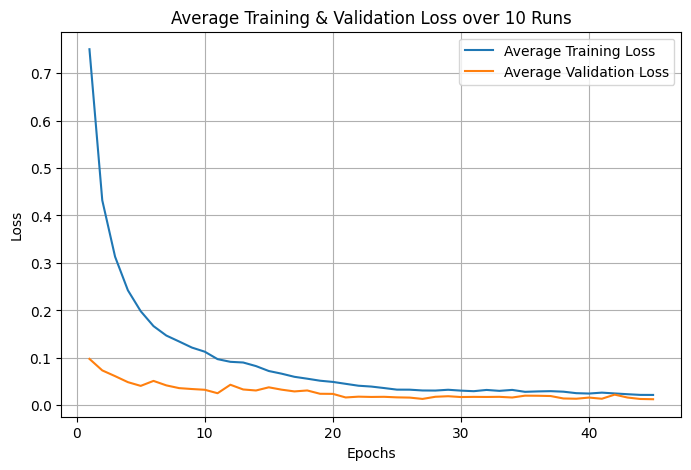

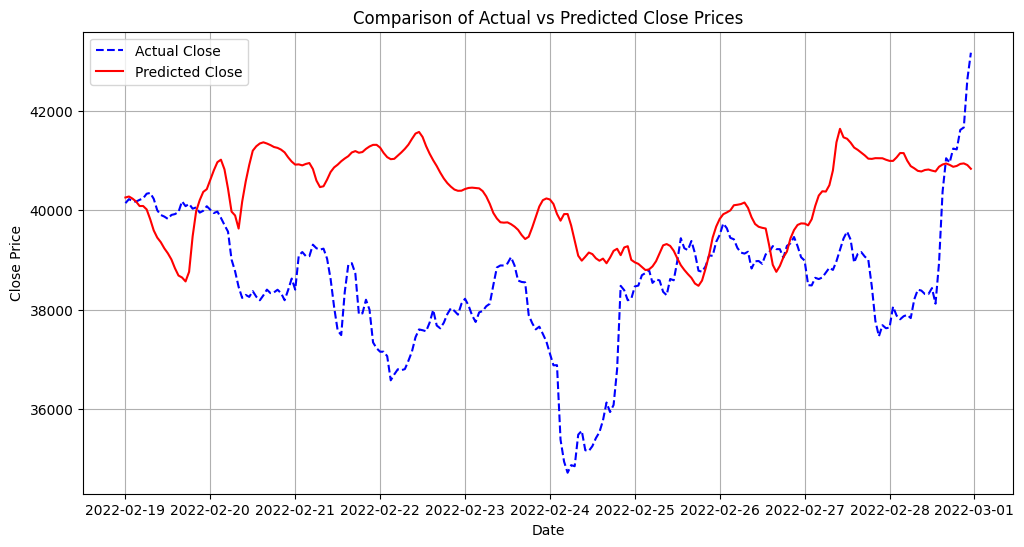

Average Metrics over 10 Runs:
Mean Absolute Error (MAE): 2671.797422690811
Mean Squared Error (MSE): 10436449.803908702
Root Mean Squared Error (RMSE): 3136.917778085876

Average Execution Times over 10 Runs:
Model Training Time: 78.2900 seconds
Predicting Time: 18.2316 seconds


In [ ]:
def main():
    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
    except ImportError:
        print("Not running on Google Colab; skipping drive mount.")

    # File path for the dataset
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"

    # Load and preprocess the dataset
    data_hourly = load_and_preprocess_data(file_path)

    # Define date ranges for training and testing
    train_end_date = '2022-02-18 23:59:59'
    test_start_date = '2022-02-19 00:00:00'
    test_end_date = '2022-02-28 23:59:59'

    # Define the feature columns and the target column
    feature_columns = ['MA_24', 'MA_240', 'hour_sin', 'hour_cos',
                       'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
    target_column = 'close'

    # Split the data into training and testing sets
    train_data, test_data = split_data(data_hourly, train_end_date, test_start_date, test_end_date,
                                       feature_columns, target_column)

    # Scale the data
    train_scaled, test_scaled, scaler = scale_data(train_data, test_data)

    # Create sequences for training
    sequence_length = 36
    x_train, y_train = create_sequences(train_scaled[:, :-1], train_scaled[:, -1], sequence_length)
    print("x_train shape:", x_train.shape)

    # # Build and train the optimized LSTM model
    # model_lstm = build_lstm_model(sequence_length, len(feature_columns))
    # history = train_model(model_lstm, x_train, y_train)

    # # Plot training history
    # plot_training_history(history)

    # # Generate predictions on the test set using the trained model
    # predicted_close_unscaled, _ = predict_test(model_lstm, train_scaled, test_scaled,
    #                                            sequence_length, feature_columns, scaler, test_data)

    # # Retrieve the actual close prices from the test data
    # actual_close = test_data['close'].values

    # # Plot the actual vs predicted close prices
    # plot_predictions(test_data, actual_close, predicted_close_unscaled)

    # # Evaluate the predictions using standard metrics
    # evaluate_predictions(actual_close, predicted_close_unscaled)

    # Run the experiment 10 times and plot/print the averaged results
    run_multiple_experiments(x_train, y_train, train_scaled, test_scaled, sequence_length,
                             feature_columns, scaler, test_data, num_runs=10)

if __name__ == "__main__":
    main()